# Quantized FACILE Training with Brevitas
This notebook walks through the steps to train and and validate the Pytorch Brevitas reconstruction of the HCAL Facile model

Initial Pytorch conversion by Vladimir Oveckhin
Pytorch to Brevitas conversion by Matthew Trahms

In [1]:
#install pandas (missing in FINN env)
!pip install --user pandas

     |################################| 9.5MB 1.9MB/s eta 0:00:01


In [1]:
#import the necessary classes and functions
from train import train
from metrics import Metrics
from quant_model import QuantNet
from quant_modelV2 import QuantNet_opt
#from quantmodelV2_with_proc import QuantNet_opt_proc

In [2]:
models_folder = 'quant_models'

X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
Number of batches per epoch: 460
# of Model parameters: 982.0
# of features: 14


Epoch 1
Ave Train Loss: 0.000921879555274681
Ave Val Loss: 0.028720845660519977
Ave Q Train Loss: 1.0376270539054135
Ave Q Val Loss: 32.39634535047743
Min Ave Val Loss: 0.028720845660519977
Saved model


Epoch 2
Ave Train Loss: 0.0004926234897117065
Ave Val Loss: 0.023508207488154607
Ave Q Train Loss: 0.5413938734946027
Ave Q Val Loss: 24.77719243367513
Min Ave Val Loss: 0.023508207488154607
Saved model


Epoch 3
Ave Train Loss: 0.00046019261373322413
Ave Val Loss: 0.022439953176275132
Ave Q Train Loss: 0.4924359054651184
Ave Q Val Loss: 23.587924049014138
Min Ave Val Loss: 0.022439953176275132
Saved model


Epoch 4
Ave Train Loss: 0.00044961466398927083
Ave Val Loss: 0.022734645281046156
Ave Q Train Loss: 0.4638570320804725
Ave Q

Ave Train Loss: 0.00042799889283368076
Ave Val Loss: 0.02043485440432079
Ave Q Train Loss: 0.4413410116934444
Ave Q Val Loss: 21.475459749736483
Min Ave Val Loss: 0.019901063588876573


Epoch 37
Ave Train Loss: 0.0004276112332871418
Ave Val Loss: 0.02328619360923767
Ave Q Train Loss: 0.43900746728912565
Ave Q Val Loss: 21.556824759831503
Min Ave Val Loss: 0.019901063588876573


Epoch 38
Ave Train Loss: 0.0004279841623420613
Ave Val Loss: 0.022712307435179515
Ave Q Train Loss: 0.4413765785960421
Ave Q Val Loss: 22.0528082469153
Min Ave Val Loss: 0.019901063588876573


Epoch 39
Ave Train Loss: 0.00042763615247320784
Ave Val Loss: 0.021082541240113124
Ave Q Train Loss: 0.44247761671295643
Ave Q Val Loss: 22.1744506472633
Min Ave Val Loss: 0.019901063588876573


Epoch 40
Ave Train Loss: 0.0004254765616100264
Ave Val Loss: 0.02147175773741707
Ave Q Train Loss: 0.43771798710255977
Ave Q Val Loss: 20.862606563265363
Min Ave Val Loss: 0.019901063588876573


Epoch 41
Ave Train Loss: 0.000425056

Ave Train Loss: 0.00042212922658220546
Ave Val Loss: 0.02044298422951547
Ave Q Train Loss: 0.43360202381376106
Ave Q Val Loss: 21.334305354527064
Min Ave Val Loss: 0.019833277378763472


Epoch 74
Ave Train Loss: 0.00042093924014784313
Ave Val Loss: 0.02143191226891109
Ave Q Train Loss: 0.43304019687301826
Ave Q Val Loss: 21.99259500654917
Min Ave Val Loss: 0.019833277378763472


Epoch 75
Ave Train Loss: 0.0004235603185540893
Ave Val Loss: 0.02114535956865265
Ave Q Train Loss: 0.4359673657933443
Ave Q Val Loss: 21.820816282242063
Min Ave Val Loss: 0.019833277378763472


Epoch 76
Ave Train Loss: 0.0004257084943882498
Ave Val Loss: 0.023245178399577973
Ave Q Train Loss: 0.4385462634130458
Ave Q Val Loss: 21.81980962601919
Min Ave Val Loss: 0.019833277378763472


Epoch 77
Ave Train Loss: 0.00042010241885515504
Ave Val Loss: 0.019486252691537614
Ave Q Train Loss: 0.43101621367769766
Ave Q Val Loss: 21.42616187201606
Min Ave Val Loss: 0.019486252691537614
Saved model


Epoch 78
Ave Train Los

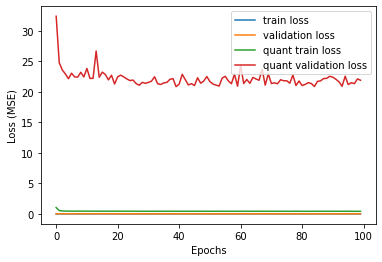

In [3]:
#train (mimicing structure in train.py)
metrics = Metrics()
model = None
try:
    model = train(QuantNet_opt, metrics=metrics, models_folder_path=models_folder, quantized=True)
except KeyboardInterrupt:
    print("Interrupted")
finally:
    metrics.plot_losses()

In [7]:
#export to onnx finn format
from brevitas.onnx import export_finn_onnx
input_shape = [500,14]
export_finn_onnx(model, input_shape, models_folder + "/facileV3_4b_500.onnx")